In [2]:
import os
from google.colab import files
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install tensorflow
!pip install findspark
!pip install pyspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

from pyspark.sql import SparkSession
import findspark

# Start a SparkSession
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,471 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,275 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,430 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis

In [4]:
uploaded = files.upload()

Saving diabetes_prediction_dataset.csv to diabetes_prediction_dataset.csv


In [5]:
import pandas as pd

# Load the first CSV file
df = pd.read_csv('diabetes_prediction_dataset.csv')

df.head(60)
num_filas, num_columnas = df.shape

print(f"Número de filas: {num_filas}")
print(f"Número de columnas: {num_columnas}")

Número de filas: 100000
Número de columnas: 9


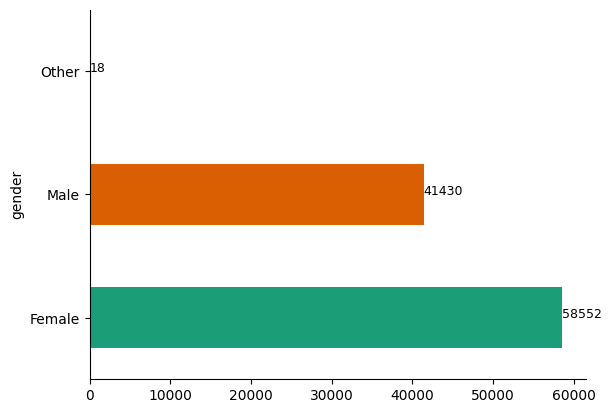

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns

df.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

grouped_gender = df.groupby('gender').size()
bar_plot = grouped_gender.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Hide the top and right spins
plt.gca().spines[['top', 'right']].set_visible(False)

# Add the amount on each bar
for index, value in enumerate(grouped_gender):
    plt.text(value, index, str(value), fontsize=9)

# Show the graph
plt.show()

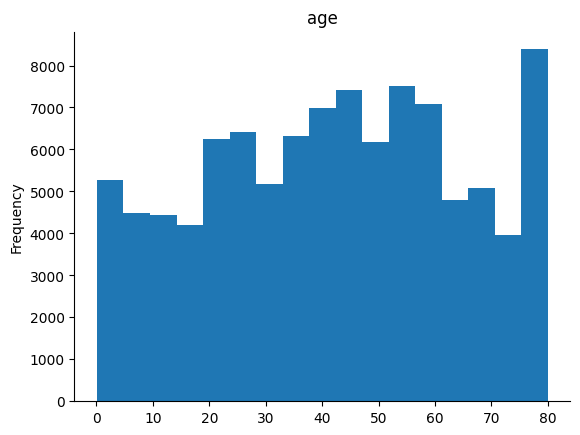

In [8]:
# Create a histogram of the 'age' column
df['age'].plot(kind='hist', bins=17, title='age')

# Hide the top and right spines for a cleaner layout
plt.gca().spines[['top', 'right']].set_visible(False)

# Show the graph
plt.show()

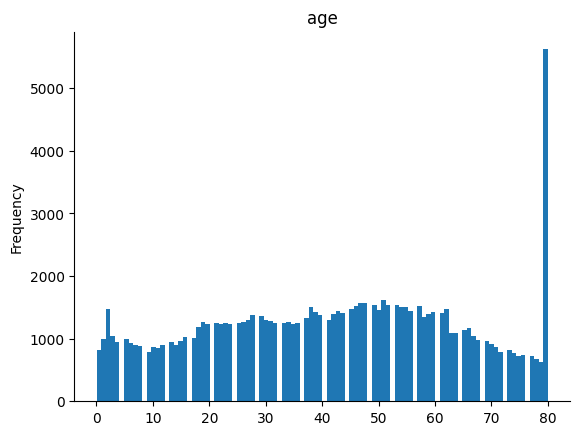

In [9]:
# Create a histogram of the 'age' column
df['age'].plot(kind='hist', bins=100, title='age')

# Hide the top and right spines for a cleaner layout
plt.gca().spines[['top', 'right']].set_visible(False)

# Show the graph
plt.show()

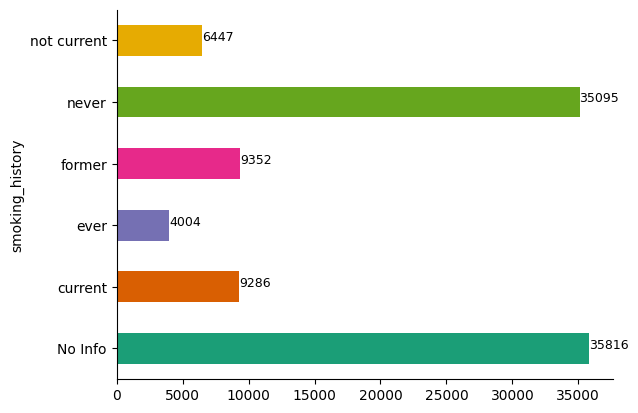

In [10]:
grouped_smoking = df.groupby('smoking_history').size()
bar_plot = grouped_smoking.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Hide the top and right spines for a cleaner layout
plt.gca().spines[['top', 'right']].set_visible(False)

# Add the amount on each bar
for index, value in enumerate(grouped_smoking):
    plt.text(value, index, str(value), fontsize=9)

# Show the graph
plt.show()

In [11]:
# Load the second csv we need
uploaded = files.upload()

Saving diabetes_prediction_dataset - balance copy.csv to diabetes_prediction_dataset - balance copy.csv


In [114]:
# Start a Spark session
spark = SparkSession.builder.appName("diabetes_analysis").getOrCreate()

# Load the CSV file with Spark
df_spark = spark.read.csv('diabetes_prediction_dataset - balance copy.csv', header=True, inferSchema=True)
df_spark = df_spark.drop('_c9', '_c10', '_c11')

# Show the first rows (equivalent to df.head() in Pandas)
df_spark.show(20)

# Get the number of rows and columns
num_filas = df_spark.count()
num_columnas = len(df_spark.columns)

print(f"Número de filas: {num_filas}")
print(f"Número de columnas: {num_columnas}")

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
|Female|20.0|           0|            0|          never|27.32|        6.6|                 85|       0|
|Female|44.0|           0|            0|          never|19.31|  

In [115]:
# Data cleaning: Filter unlikely values in 'age' column
df_spark = df_spark.filter(df_spark['age'] >= 1)

# Get the number of rows and columns
num_filas = df_spark.count()
num_columnas = len(df_spark.columns)

print(f"Número de filas: {num_filas}")
print(f"Número de columnas: {num_columnas}")

# See the unique categories in the 'gender' column
df_spark.select('gender').distinct().show()

# Show the first n unique categories in the 'gender' column

# df_spark.select('gender').distinct().show(n)

Número de filas: 152778
Número de columnas: 9
+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [117]:
import pyspark
import py4j

print(f"Versión de PySpark: {pyspark.__version__}")
print(f"Versión de Py4J: {py4j.__version__}")

Versión de PySpark: 3.5.0
Versión de Py4J: 0.10.9.7


In [118]:
# Convert Spark DataFrame to Pandas DataFrame
df_pandas = pd.DataFrame(df_spark.collect(), columns=df_spark.columns)

In [119]:
df_pandas.head(20)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf

# One-Hot Encoding for Categorical Variables
df_encoded = pd.get_dummies(df_pandas, columns=['gender', 'smoking_history'])

df_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,1,0,0,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,1,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,0,1,0,0,0,0


In [121]:
# Normalization of numerical variables
scaler = StandardScaler()
df_encoded[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(df_encoded[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])
df_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1.428240,0,1,-0.527647,0.453365,-0.326360,0,1,0,0,0,0,0,0,1,0
1,0.235477,0,0,-0.235210,0.453365,-1.420384,0,1,0,0,1,0,0,0,0,0
2,-0.957287,0,0,-0.235210,-0.257225,0.001847,0,0,1,0,0,0,0,0,1,0
3,-0.590283,0,0,-0.766540,-0.809906,-0.052854,0,1,0,0,0,1,0,0,0,0
4,1.244738,1,1,-1.220985,-0.967815,-0.052854,0,0,1,0,0,1,0,0,0,0


In [122]:
# Split the data into features (X) and target (y)
X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']

In [123]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [124]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [125]:
# Delete empty columns
df_encoded = df_encoded.fillna(0)

In [126]:
# Look the type of the train data
X_train.dtypes
y_train.dtypes

dtype('int64')

In [127]:
# Convert Pandas DataFrames to NumPy arrays for compatibility with machine learning algorithms
X_train = X_train.values
y_train = y_train.values

In [78]:
# Train the model with a validation set
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
3056/3056 [==============================] - 17s 5ms/step - loss: 0.1743 - accuracy: 0.9122 - val_loss: 0.1775 - val_accuracy: 0.9106
Epoch 2/100
3056/3056 [==============================] - 17s 6ms/step - loss: 0.1741 - accuracy: 0.9125 - val_loss: 0.1788 - val_accuracy: 0.9098
Epoch 3/100
3056/3056 [==============================] - 7s 2ms/step - loss: 0.1741 - accuracy: 0.9118 - val_loss: 0.1775 - val_accuracy: 0.9109
Epoch 4/100
3056/3056 [==============================] - 8s 3ms/step - loss: 0.1740 - accuracy: 0.9122 - val_loss: 0.1798 - val_accuracy: 0.9106
Epoch 5/100
3056/3056 [==============================] - 7s 2ms/step - loss: 0.1740 - accuracy: 0.9127 - val_loss: 0.1778 - val_accuracy: 0.9105
Epoch 6/100
3056/3056 [==============================] - 10s 3ms/step - loss: 0.1739 - accuracy: 0.9127 - val_loss: 0.1780 - val_accuracy: 0.9114
Epoch 7/100
3056/3056 [==============================] - 7s 2ms/step - loss: 0.1739 - accuracy: 0.9132 - val_loss: 0.1775 - val

In [129]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy*100}%")
print(f"Loss: {loss*100}%")

955/955 [==============================] - 5s 4ms/step - loss: 0.7264 - accuracy: 0.5080
Accuracy: 50.80180764198303%
Loss: 72.63514399528503%


In [130]:
# Make an example prediction
new_patient = pd.DataFrame({
    'age': [80],
    'hypertension': [0],
    'heart_disease': [1],
    'bmi': [25.19],
    'HbA1c_level': [6.6],
    'blood_glucose_level': [140],
    'gender_Female': [1],
    'gender_Male': [0],
    'gender_Other': [0],
    'smoking_history_No Info': [0],
    'smoking_history_current': [0],
    'smoking_history_ever': [0],
    'smoking_history_former': [0],
    'smoking_history_never': [1],
    'smoking_history_not current': [0]
})

In [131]:
# Normalize new patient data
# We use the same scaler that I used for the training data
new_patient[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.transform(new_patient[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])

In [132]:
# Make the prediction with the model
prediction = model.predict(new_patient)

1/1 [==============================] - 0s 87ms/step


In [133]:
print(f"Predicted probability of having diabetes: {prediction[0][0] * 100}%")

Predicted probability of having diabetes: 50.119686126708984%


In [134]:
# Interpretar la predicción basada en el umbral del 65%
predicted_diabetes = (prediction[0][0] > 0.65).astype(int)
# Print a personalized message based on the prediction
if predicted_diabetes == 1:
    print("Diabetes Prediction: Probably yes")
else:
    print("Diabetes Prediction: Probably no")

Diabetes Prediction: Probably no


In [135]:
# Make an example prediction
new_patient2 = pd.DataFrame({
    'age': [20],
    'hypertension': [0],
    'heart_disease': [0],
    'bmi': [23.86],
    'HbA1c_level': [5.7],
    'blood_glucose_level': [85],
    'gender_Female': [1],
    'gender_Male': [0],
    'gender_Other': [0],
    'smoking_history_No Info': [0],
    'smoking_history_current': [0],
    'smoking_history_ever': [0],
    'smoking_history_former': [0],
    'smoking_history_never': [1],
    'smoking_history_not current': [0]
})

In [136]:
# Normalize new patient data
# We use the same scaler that I used for the training data
new_patient2[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.transform(new_patient2[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])

In [137]:
# Make the prediction with the model
prediction2 = model.predict(new_patient2)

1/1 [==============================] - 0s 21ms/step


In [138]:
print(f"Predicted probability of having diabetes: {prediction2[0][0] * 100}%")

Predicted probability of having diabetes: 45.298007130622864%


In [139]:
# Interpret prediction based on 65% threshold
predicted_diabetes2 = (prediction2[0][0] > 0.65).astype(int)
# Print a personalized message based on the prediction
if predicted_diabetes2 == 1:
    print("Diabetes Prediction: Probably yes")
else:
    print("Diabetes Prediction: Probably no")

Diabetes Prediction: Probably no
